In [21]:
!pip install geopandas pandas numpy matplotlib seaborn os


  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---- ----------------------------------- 1.8/16.2 MB 10.1 MB/s eta 0:00:02
   --------- ------------------------------ 3.9/16.2 MB 9.8 MB/s eta 0:00:02
   ------------- -------------------------- 5.5/16.2 MB 9.3 MB/s eta 0:00:02
   ------------------ --------------------- 7.3/16.2 MB 8.9 MB/s eta 0:00:01
   ----------------------- ---------------- 9.4/16.2 MB 9.2 MB/s eta 0:00:01
   ---------------------------- ----------- 11.5/16.2 MB 9.4 MB/s eta 0:00:01
   --------------------------------- ------ 13.6/16.2 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------  16.0/16.2 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 16.2/16.2 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ------------- -------------------------

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

In [48]:
all_files = []
for folder in os.listdir('data'):
    folder_path = os.path.join('data', folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv') or file.endswith('.CSV'):
                all_files.append(os.path.join(folder_path, file))

In [49]:
print(f"Found {len(all_files)} CSV files.")
if len(all_files) == 0:
    raise ValueError("No CSV files found! Check if the 'data' folder contains subfolders with CSVs.")

df_list = [pd.read_csv(file, low_memory=False) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

print(df.shape)
print(df.columns)
print(df.head())
print(df.dtypes)


Found 102 CSV files.
(6562768, 26)
Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Outcome type',
       'Type', 'Date', 'Part of a policing operation', 'Policing operation',
       'Gender', 'Age range', 'Self-defined ethnicity',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')
                                            Crime ID    Month  \
0  8bef821379164ea6e14c64ae08e422f16eda2f4aee99ee...  2022-03   
1  8078b4aeb60f5ad85077b6dda3706ceee01e57032ee94b...  2022-03   
2  f837bffb239dc5c6102f725d5a283ce98c4e8616d77574...  2022-03   
3  332e73c2922532e067520489f04f835c4b42fa7f7c6dc4...  2022-03   
4  4c72a74bcabba08af1d6b8e150223520b78f6430100800...  2022-03   

                   Reported by        

In [50]:
burglary_df = df[df['Crime type'].str.contains('burglary', case=False, na=False)]

burglary_df = burglary_df[burglary_df['Falls within'].str.contains('Metropolitan Police Service', case=False, na=False)]

print("Total Burglary Cases:", burglary_df.shape[0])
print("Date Range:", burglary_df['Month'].min(), "to", burglary_df['Month'].max())
print("Unique Locations:", burglary_df['LSOA name'].nunique())

Total Burglary Cases: 161381
Date Range: 2022-03 to 2025-02
Unique Locations: 5373


In [58]:
burglary_df[['Borough Name','Ward Code']] = (
    burglary_df['LSOA name']
      .str.extract(r'^([^\d]+?)\s+(\d+\w+)$')
)

burglary_by_lsoa = (
    burglary_df
      .groupby('LSOA name')
      .size()
      .reset_index(name='Burglary Count')
)

burglary_by_ward = (
    burglary_df
      .groupby('Ward Code')
      .size()
      .reset_index(name='Burglary Count')
      .sort_values('Burglary Count', ascending=False)
)

burglary_by_borough = (
    burglary_df
      .groupby('Borough Name')
      .size()
      .reset_index(name='Burglary Count')
      .sort_values('Burglary Count', ascending=False)
)

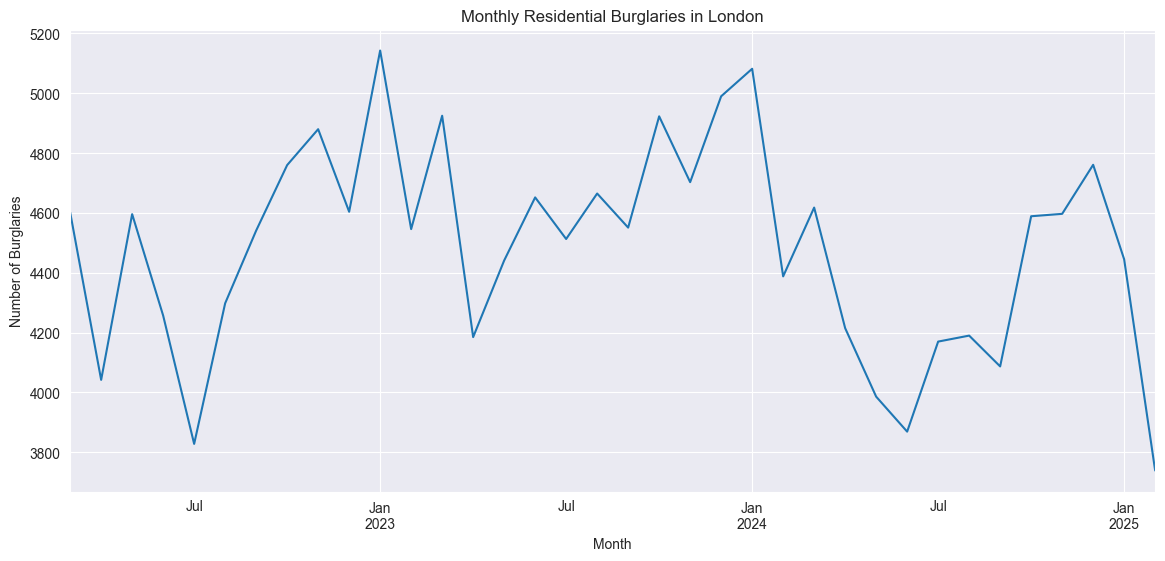

In [52]:
burglary_df['Month'] = pd.to_datetime(burglary_df['Month'])
burglary_by_month = burglary_df.groupby(burglary_df['Month']).size()

plt.figure(figsize=(14,6))
burglary_by_month.plot()
plt.title('Monthly Residential Burglaries in London')
plt.xlabel('Month')
plt.ylabel('Number of Burglaries')
plt.grid(True)
plt.show()

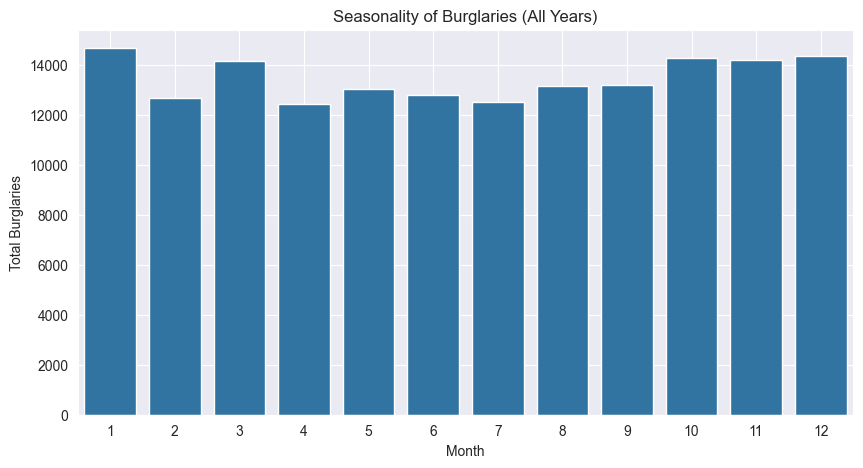

In [53]:
burglary_df['Year'] = burglary_df['Month'].dt.year
burglary_df['Month_num'] = burglary_df['Month'].dt.month
burglary_seasonality = burglary_df.groupby('Month_num').size()

plt.figure(figsize=(10,5))
sns.barplot(x=burglary_seasonality.index, y=burglary_seasonality.values)
plt.title('Seasonality of Burglaries (All Years)')
plt.xlabel('Month')
plt.ylabel('Total Burglaries')
plt.grid(True)
plt.show()


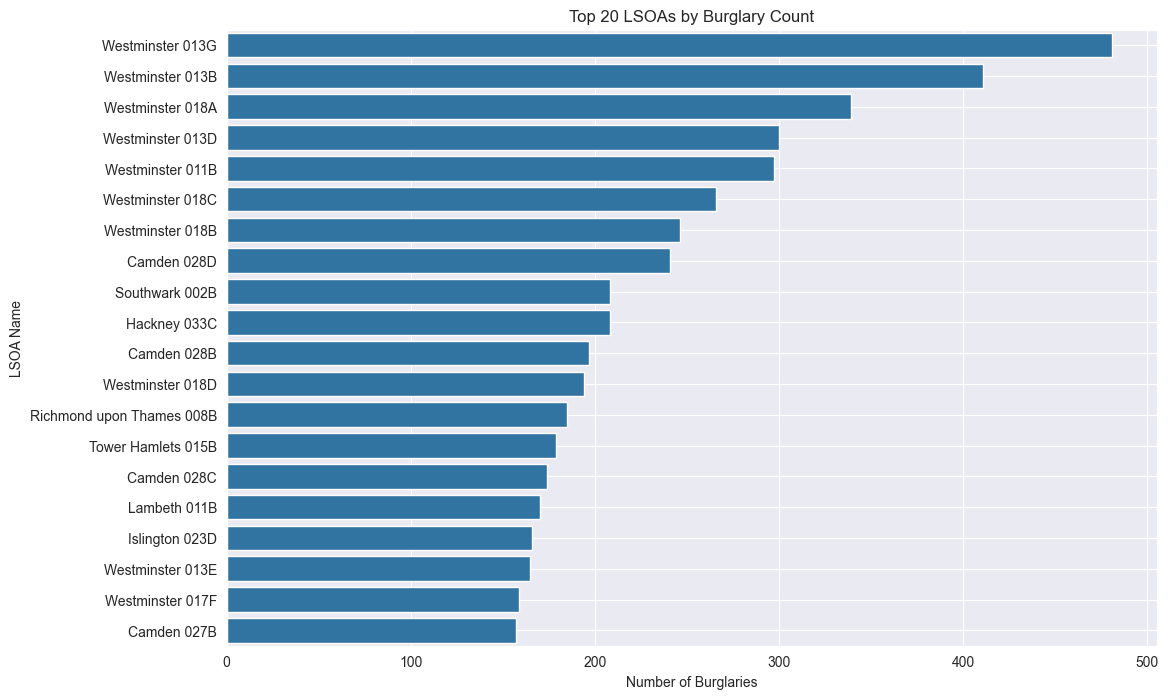

In [54]:
burglary_by_lsoa = burglary_df.groupby('LSOA name').size().sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(y=burglary_by_lsoa.index[:20], x=burglary_by_lsoa.values[:20])
plt.title('Top 20 LSOAs by Burglary Count')
plt.xlabel('Number of Burglaries')
plt.ylabel('LSOA Name')
plt.grid(True)
plt.show()

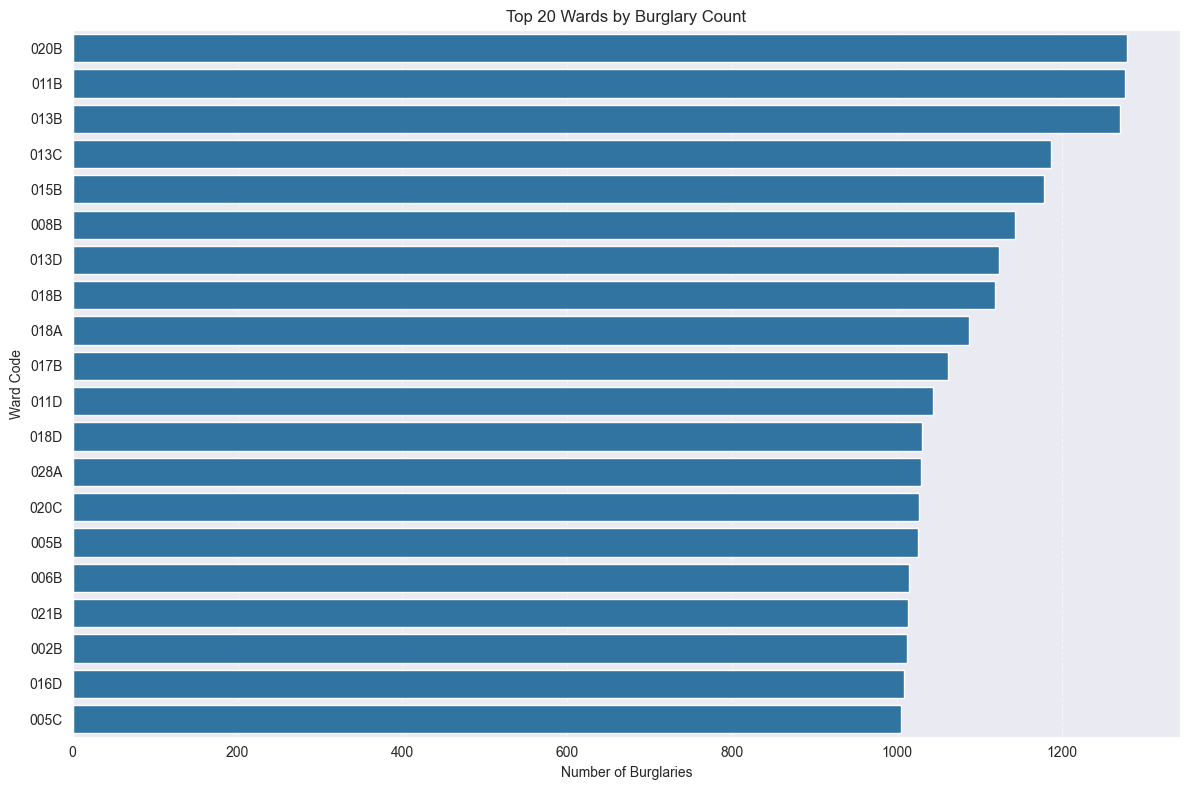

In [60]:
burglary_by_ward = (
    burglary_df
      .groupby('Ward Code')
      .size()
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,8))
sns.barplot(
    y=burglary_by_ward.index[:20],
    x=burglary_by_ward.values[:20],
)
plt.title('Top 20 Wards by Burglary Count')
plt.xlabel('Number of Burglaries')
plt.ylabel('Ward Code')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

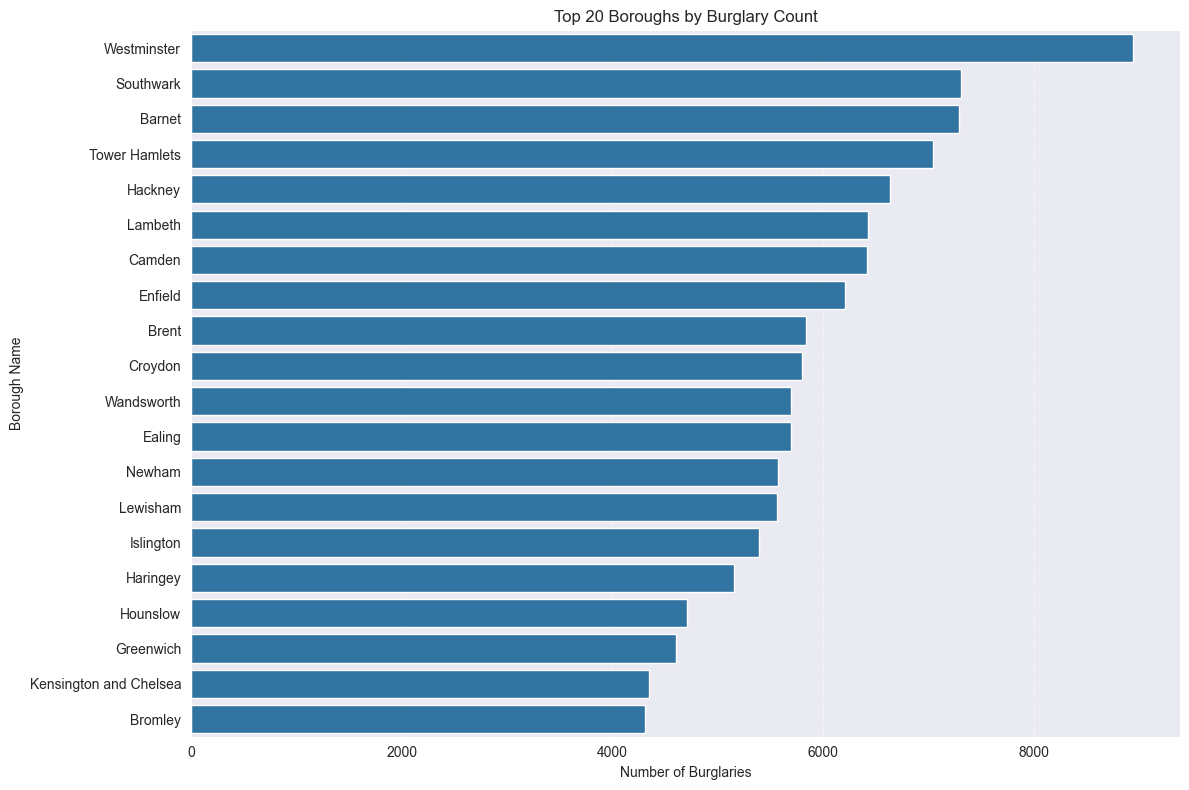

In [62]:
burglary_by_borough = (
    burglary_df
      .groupby('Borough Name')
      .size()
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,8))
sns.barplot(
    y=burglary_by_borough.index[:20],
    x=burglary_by_borough.values[:20],
)
plt.title('Top 20 Boroughs by Burglary Count')
plt.xlabel('Number of Burglaries')
plt.ylabel('Borough Name')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

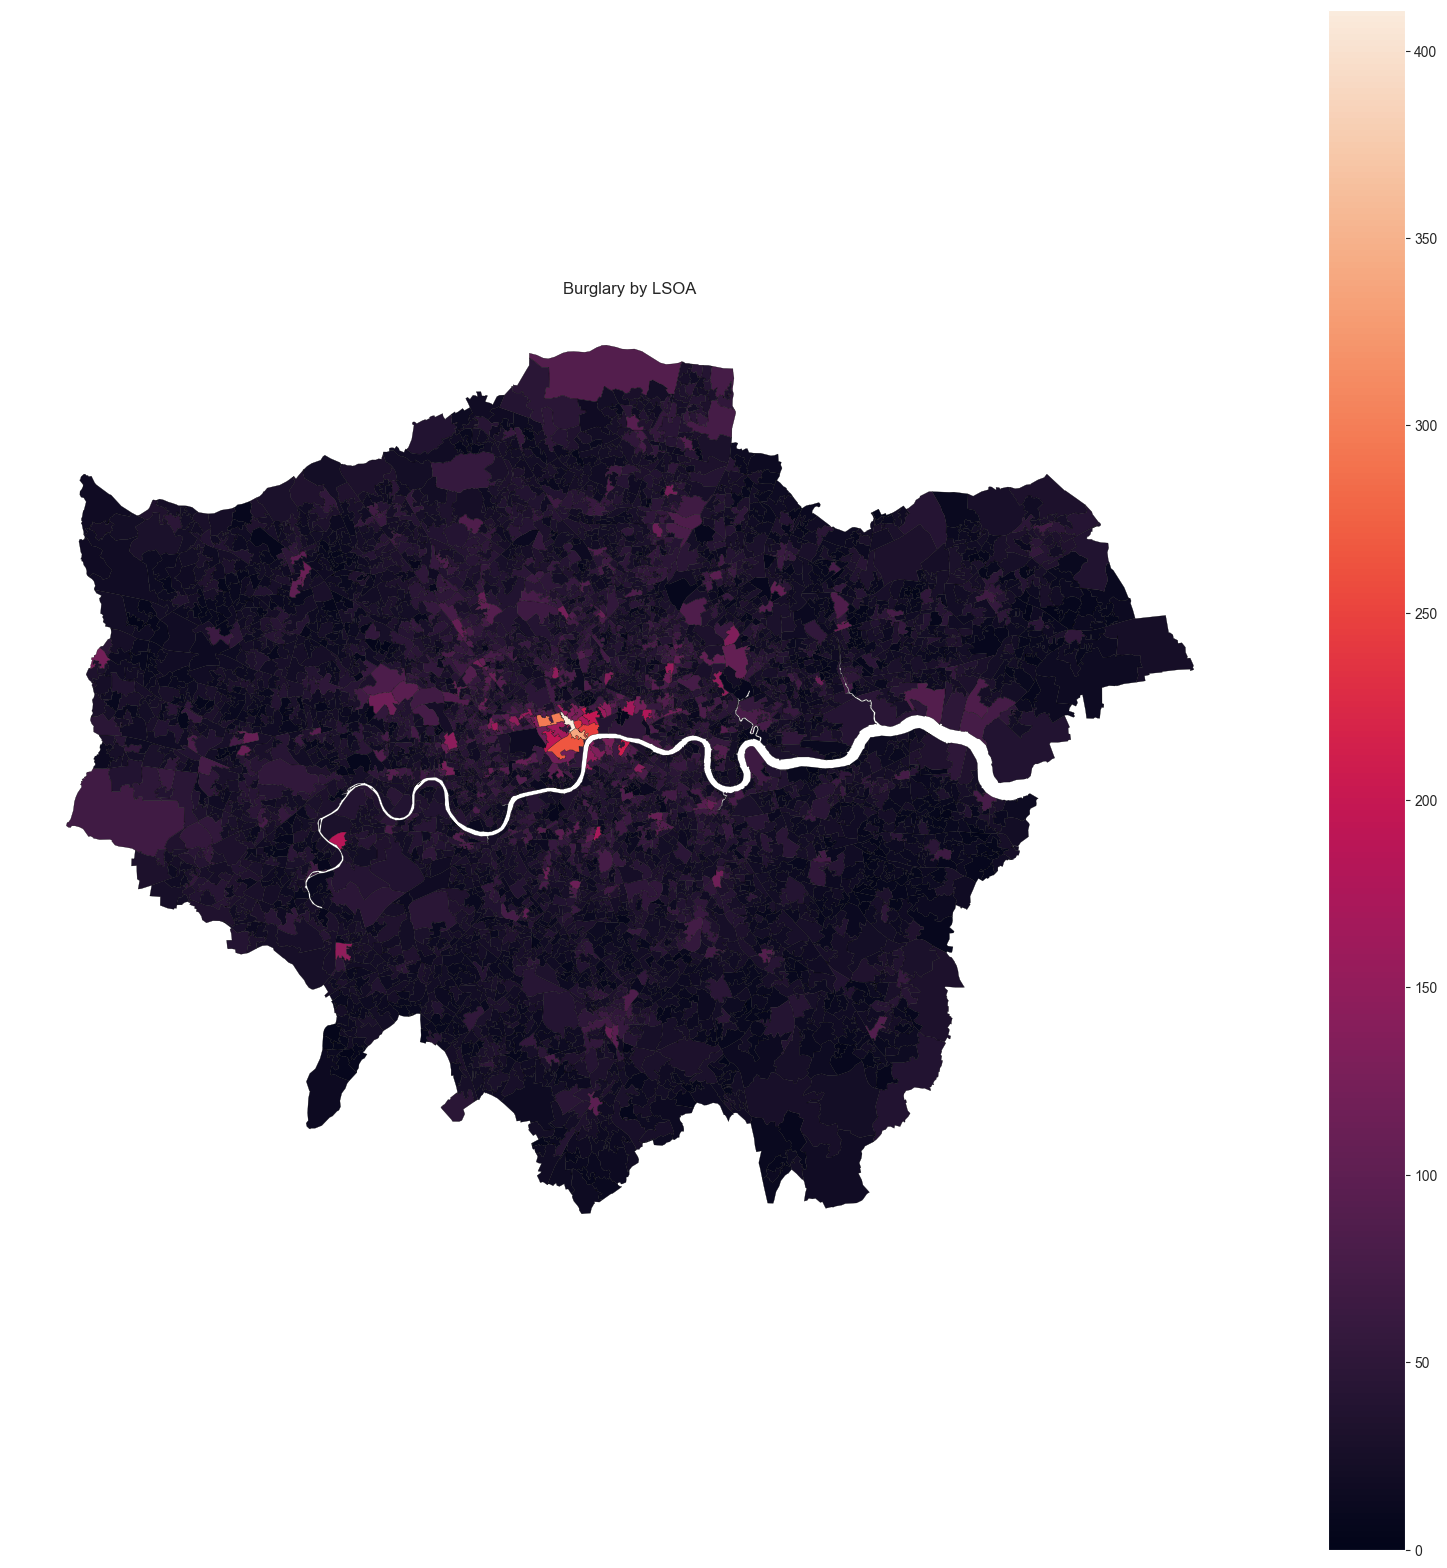

In [45]:
lsoa_shapes = (
    gpd.read_file('boundaries/LSOA_2011_London_gen_MHW.shp')
       .to_crs(epsg=4326)
)
# Merge counts onto the LSOA polygons
lsoa_shapes = lsoa_shapes.merge(
    burglary_by_lsoa,
    left_on='LSOA11NM',   
    right_on='LSOA name',
    how='left'
)
lsoa_shapes['Burglary Count'] = lsoa_shapes['Burglary Count'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(20,20))
lsoa_shapes.plot(
    column='Burglary Count',
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title('Burglary by LSOA')
ax.axis('off')
plt.show()

C:\Users\Junior\AppData\Local\Temp\ipykernel_12208\1826262517.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lsoa_centroids['geometry'] = lsoa_centroids.geometry.centroid


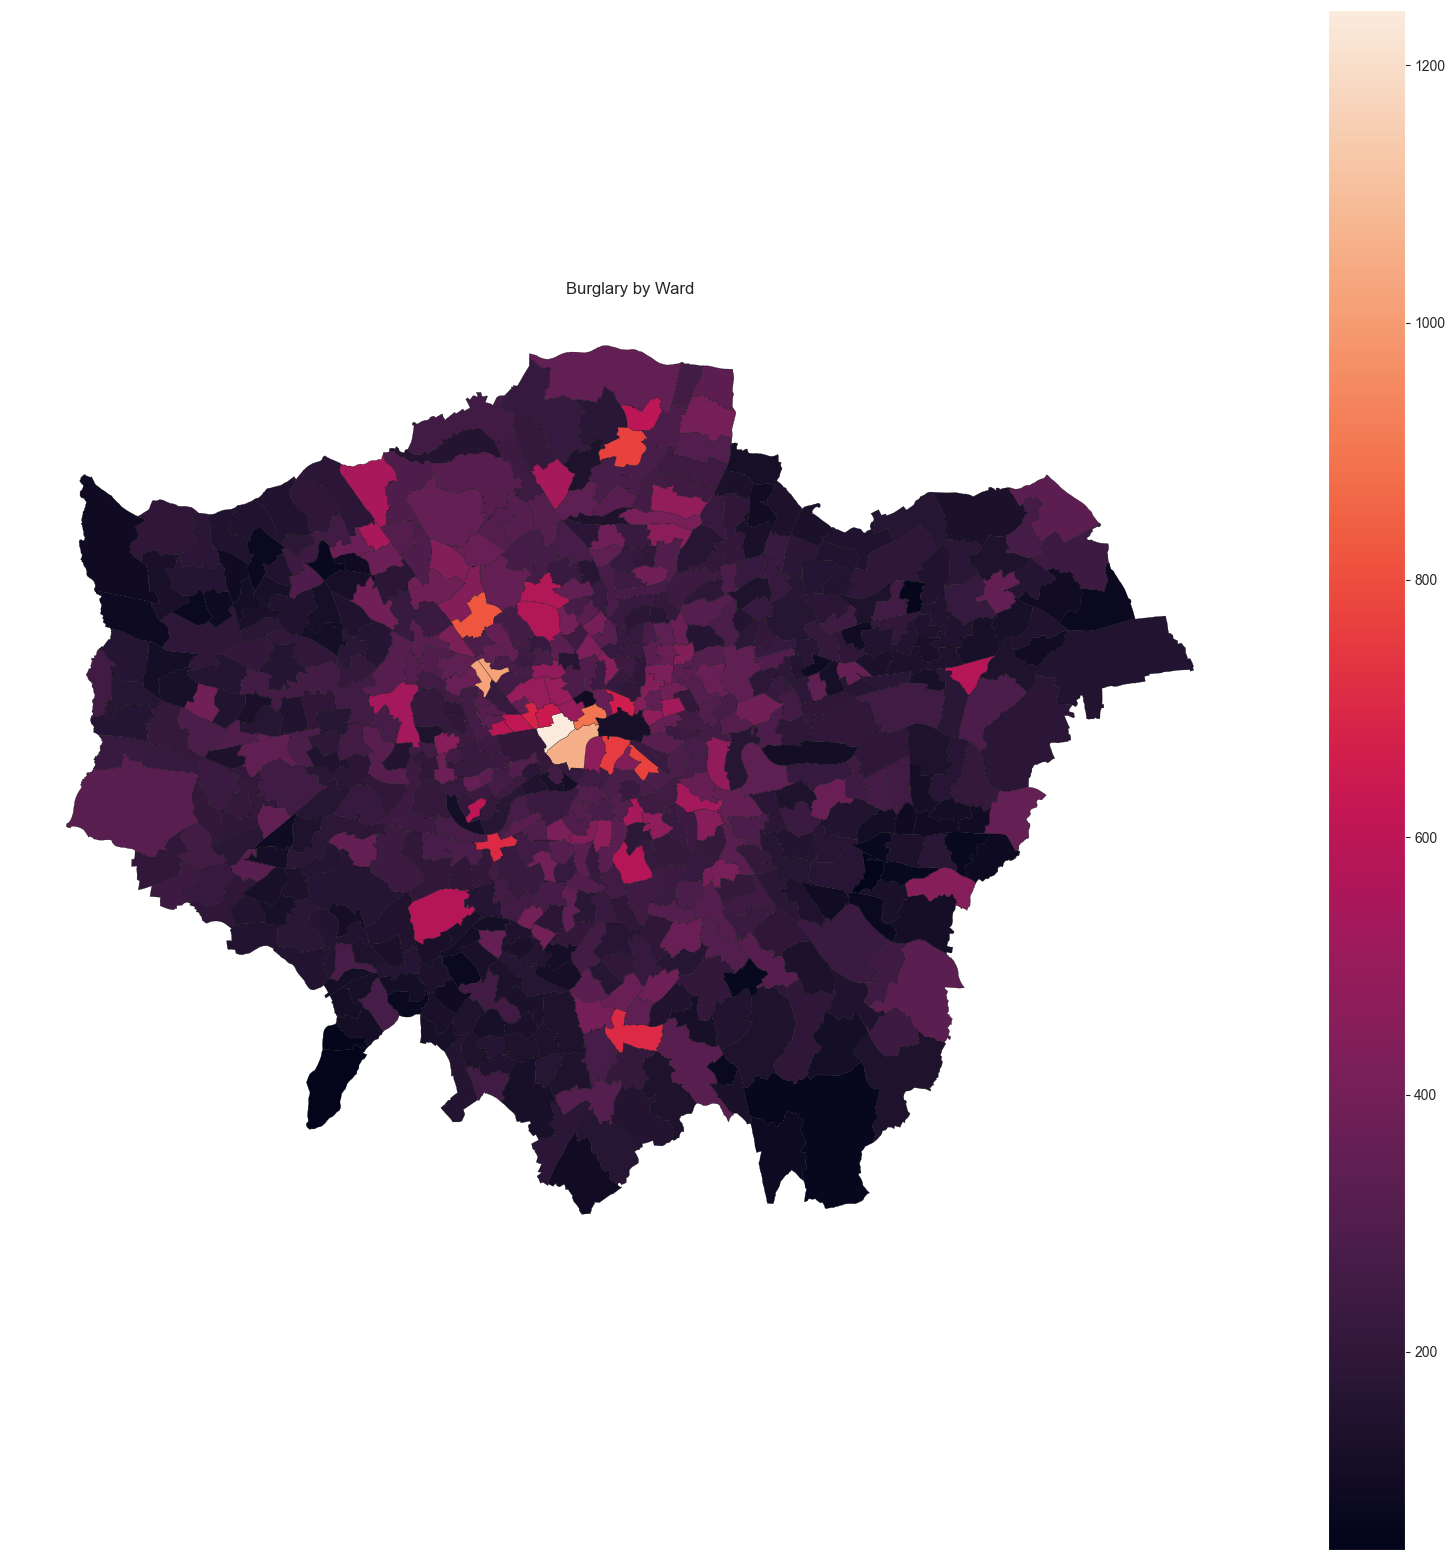

In [44]:
ward_shapes = (
    gpd.read_file('boundaries/London_Ward_CityMerged.shp')
       .to_crs(epsg=4326)
)

lsoa_centroids = lsoa_shapes.copy()
lsoa_centroids['geometry'] = lsoa_centroids.geometry.centroid
lsoa_centroids = lsoa_centroids.set_geometry('geometry')

lsoa_with_ward = gpd.sjoin(
    lsoa_centroids,
    ward_shapes[['NAME','geometry']].rename(columns={'geometry':'ward_geom'})
                .set_geometry('ward_geom'),
    how='left',
    predicate='within'
)

ward_counts = (
    lsoa_with_ward
      .groupby('NAME')['Burglary Count']
      .sum()
      .reset_index(name='Burglary Count')
)

ward_map = ward_shapes.merge(
    ward_counts,
    left_on='NAME',
    right_on='NAME',
    how='left'
)
ward_map['Burglary Count'] = ward_map['Burglary Count'].fillna(0)

fig, ax = plt.subplots(figsize=(20,20))
ward_map.plot(
    column='Burglary Count',
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title('Burglary by Ward')
ax.axis('off')
plt.show()

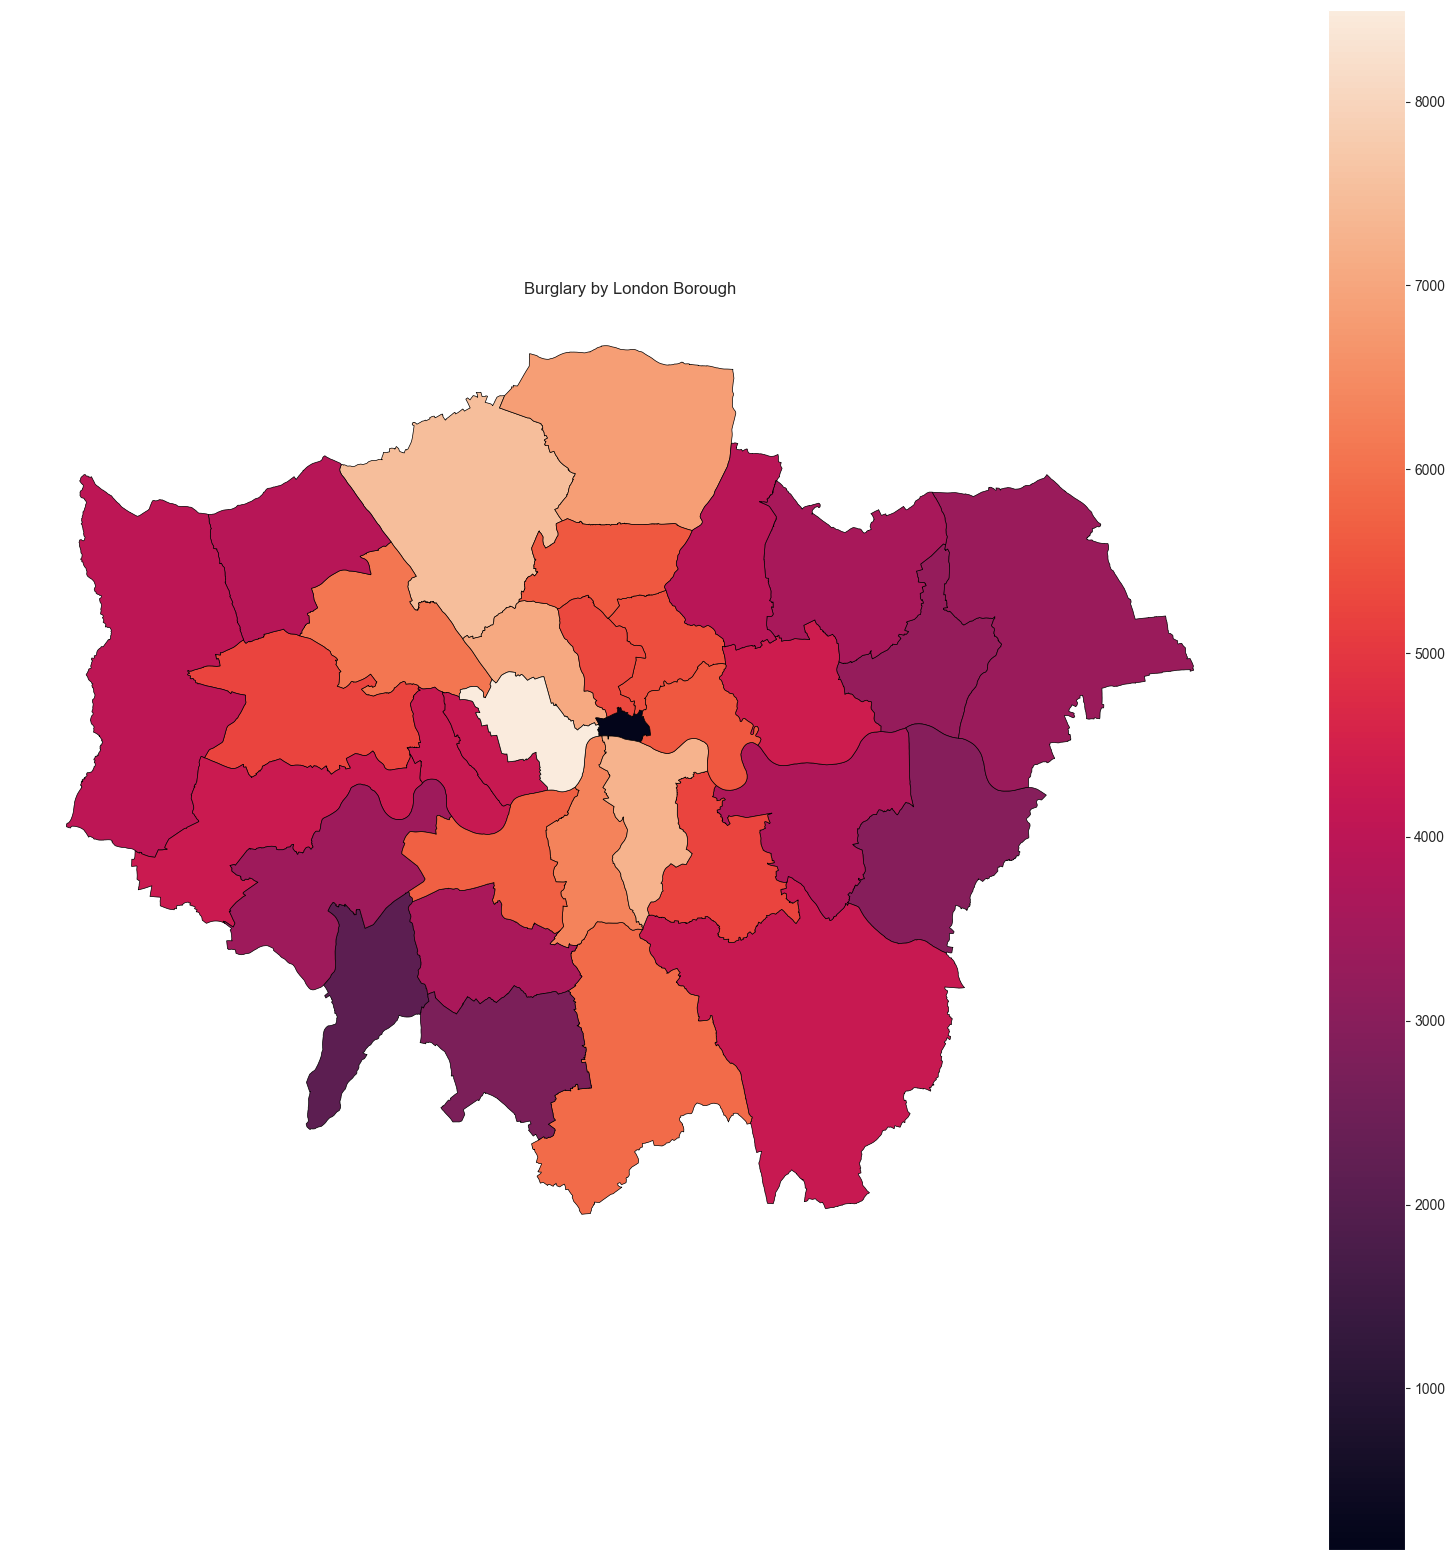

In [43]:
borough_map = (
    ward_map[['BOROUGH','Burglary Count','geometry']]
      .dissolve(by='BOROUGH', aggfunc='sum')
)
borough_map['Burglary Count'] = borough_map['Burglary Count'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(20,20))
borough_map.plot(
    column='Burglary Count',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title('Burglary by London Borough')
ax.axis('off')
plt.show()

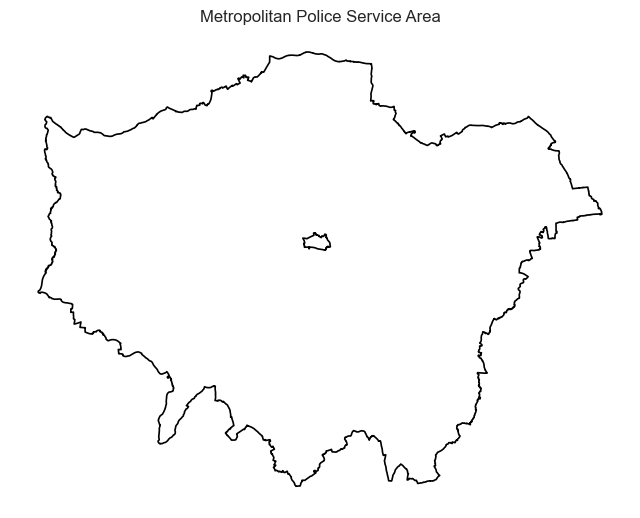

In [66]:
force_gdf = gpd.read_file(
    'boundaries/metropolitan.kml',
    driver='KML'
).to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(8,8))
force_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.2)
ax.set_title('Metropolitan Police Service Area')
ax.axis('off')
plt.show()

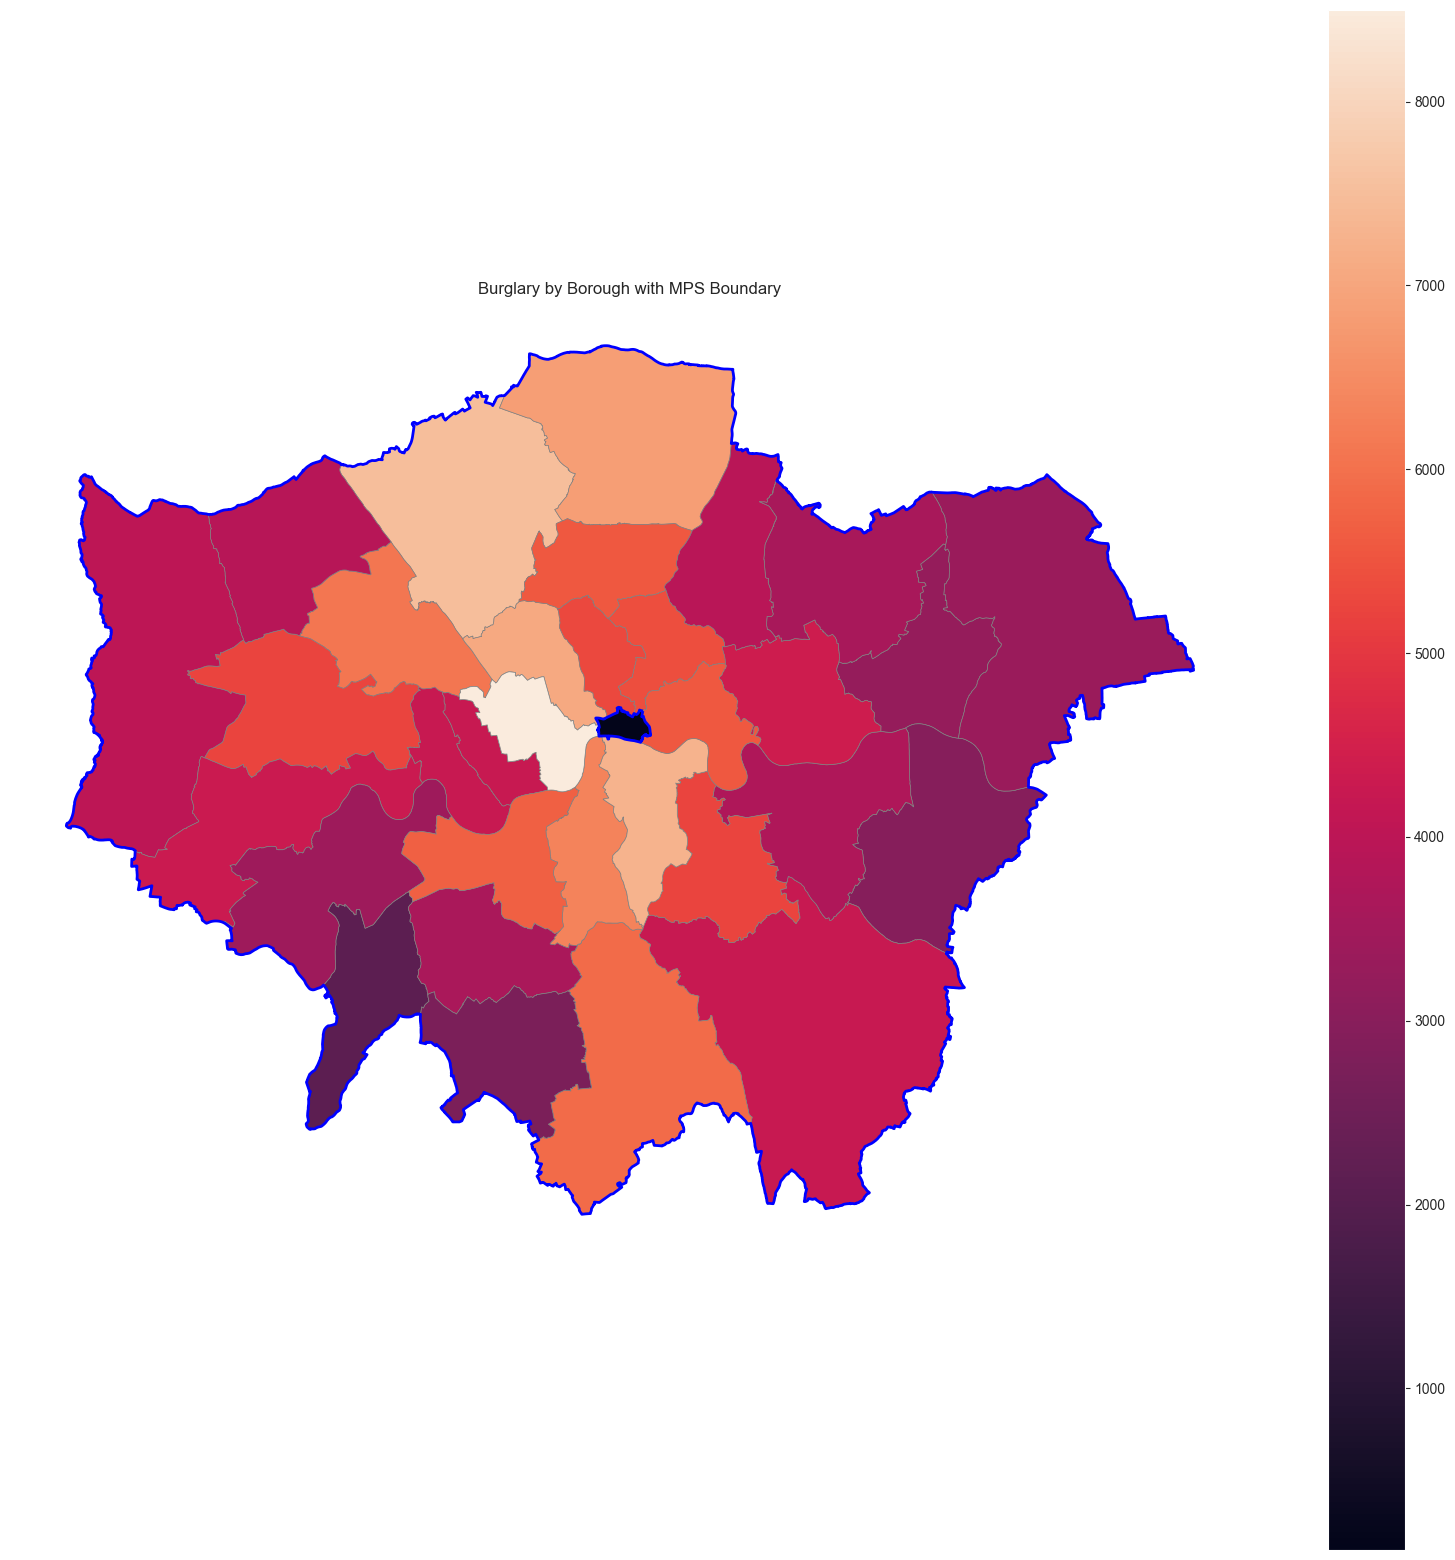

In [74]:
fig, ax = plt.subplots(figsize=(20,20))
borough_map.plot(
    column='Burglary Count',
    legend=True,
    edgecolor='grey',
    linewidth=0.5,
    ax=ax
)

force_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

ax.set_title('Burglary by Borough with MPS Boundary')
ax.axis('off')
plt.show()


In [70]:
from shapely.ops import unary_union

mps_union = unary_union(force_gdf.geometry)
borough_map['in_mps'] = borough_map.centroid.within(mps_union)

inside = borough_map[borough_map['in_mps']]
outside = borough_map[~borough_map['in_mps']]

print("Inside MPS:", inside.index.tolist())
print("Outside MPS:", outside.index.tolist())
print("Total burglaries inside:", inside['Burglary Count'].sum())
print("Total burglaries outside:", outside['Burglary Count'].sum())


Inside MPS: ['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']
Outside MPS: ['City of London']
Total burglaries inside: 155703.0
Total burglaries outside: 121.0


C:\Users\Junior\AppData\Local\Temp\ipykernel_12208\3834091404.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  borough_map['in_mps'] = borough_map.centroid.within(mps_union)


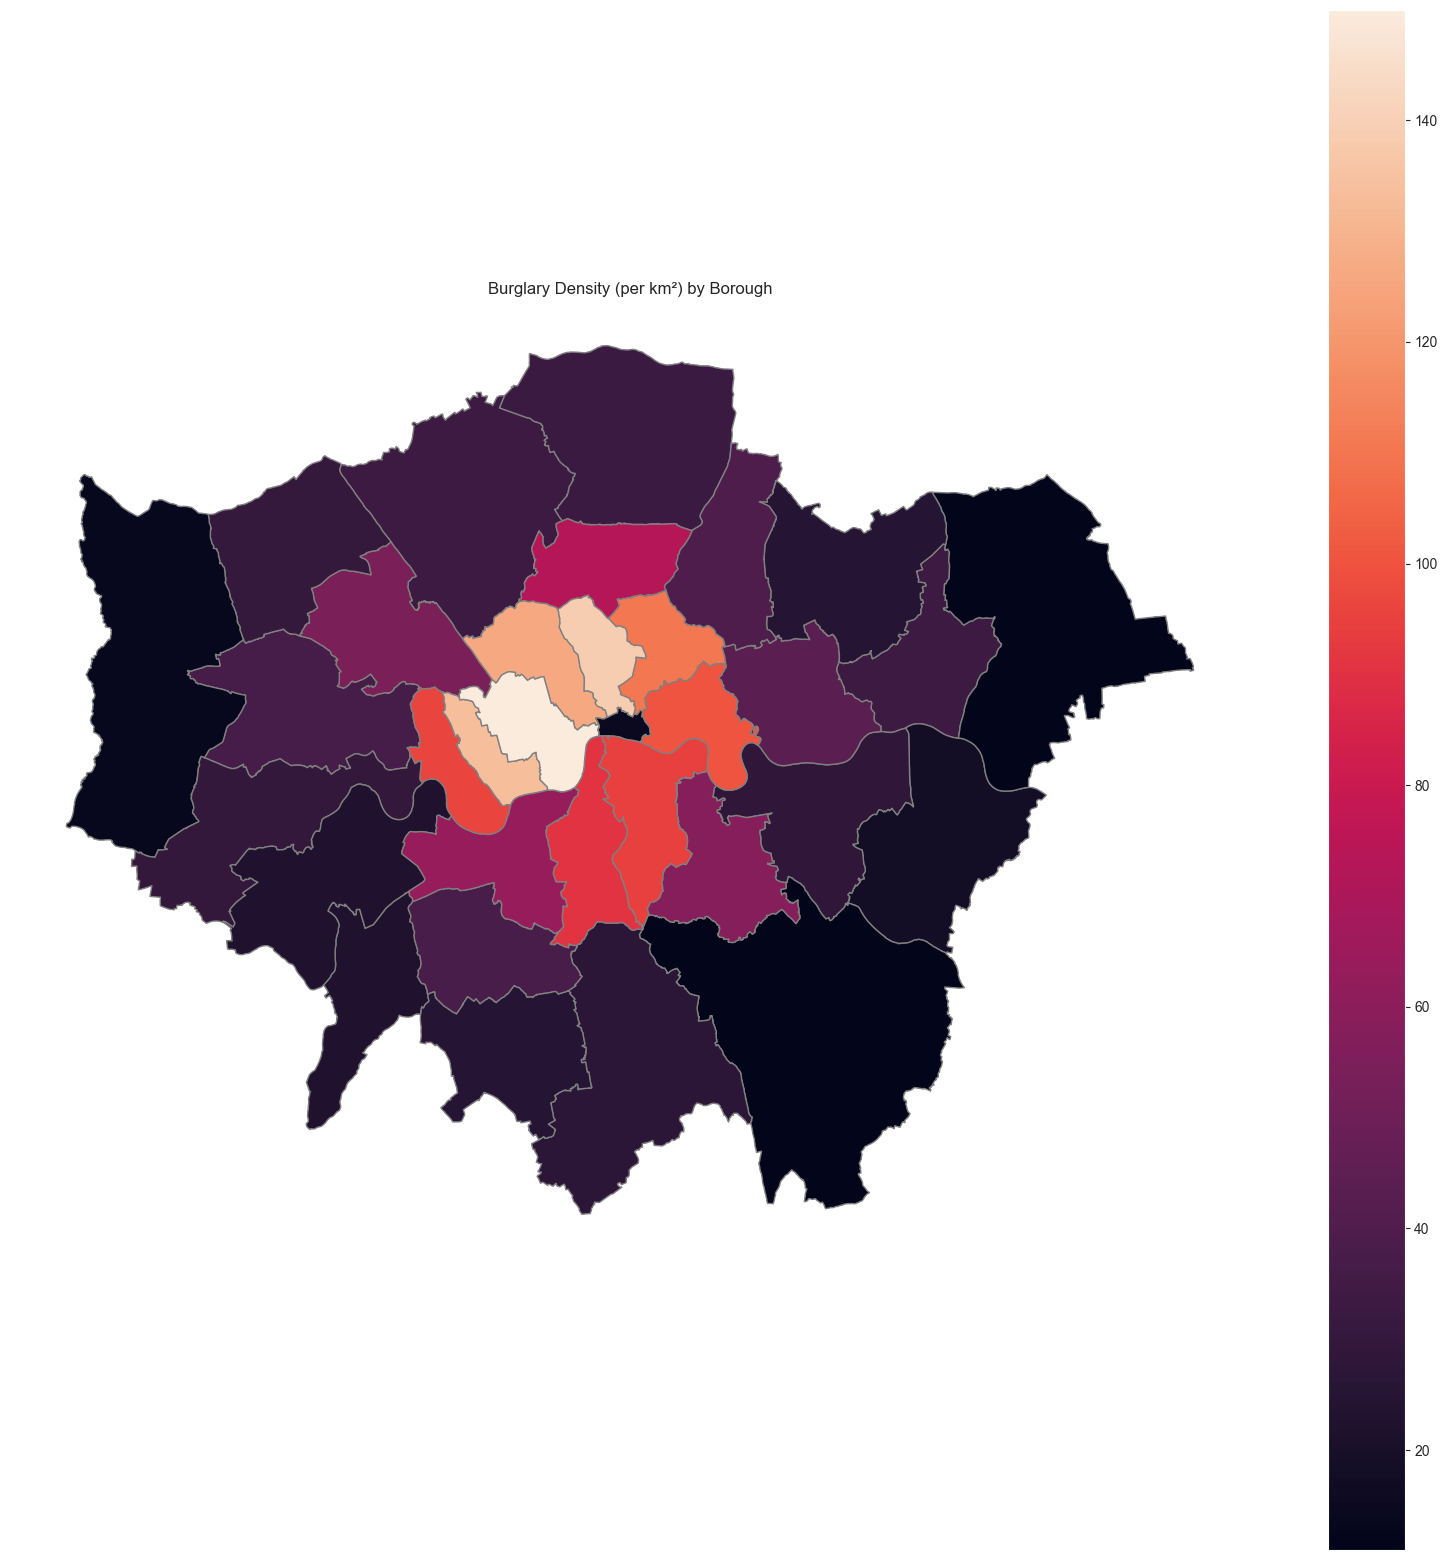

In [73]:

borough_metric = borough_map.to_crs(epsg=3395)
borough_map['area_km2'] = borough_metric.geometry.area / 1e6
borough_map['burglaries_per_km2'] = borough_map['Burglary Count'] / borough_map['area_km2']

fig, ax = plt.subplots(figsize=(20,20))
borough_map.plot(
    column='burglaries_per_km2',
    legend=True,
    edgecolor='grey',
    ax=ax
)
ax.set_title('Burglary Density (per km²) by Borough')
ax.axis('off')
plt.show()
